In [1]:
# Importar las librerías necesarias
from flask import Flask, request, jsonify
from flask_restful import Api, Resource
from flask_cors import CORS
import cv2

from torchvision import transforms, models
from PIL import Image
import io
import numpy as np
import threading
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


import json

# Crear la aplicación Flask
app = Flask(__name__)
CORS(app)  # Habilitar CORS para todas las rutas


# Cargar el archivo JSON con los nombres de los medicamentos
with open('medicamentos.json', 'r') as f:
    medicamentos_data = json.load(f)
    medicamentos = medicamentos_data['medicamentos']

# Definir y cargar el modelo PyTorch
model_path = 'resnet50.pth'
model = models.resnet50(pretrained=False)  # Definir la arquitectura del modelo

# Redefinir la capa fully connected para que coincida con el modelo entrenado
num_classes = 78  # Número de clases del modelo entrenado
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

# Cargar el estado del modelo
model.load_state_dict(torch.load(model_path))
model.eval()  # Modo de evaluación


# Usar los valores calculados de media y desviación estándar
calculated_mean = [0.8722, 0.8722, 0.8722]
calculated_std = [0.2645,0.2645,0.2645]


preprocess = transforms.Compose([
    transforms.Resize((224, 224)),  # Redimensionar a 224x224
    transforms.ToTensor(),
    transforms.Normalize(calculated_mean,calculated_std)
])


def show_tensor_image(tensor):
    tensor = tensor.squeeze(0)  # Eliminar la dimensión de lote
    tensor = tensor.permute(1, 2, 0)  # Cambiar de [C, H, W] a [H, W, C]
    tensor = tensor.numpy()
    tensor = tensor * np.array(calculated_std) + np.array(calculated_mean)
    tensor = np.clip(tensor, 0, 1)  # Asegurarse de que los valores estén en el rango [0, 1]
    plt.imshow(tensor)
    plt.title("Imagen procesada")
    plt.axis('off')
    plt.show()




def preprocess_image(image_bytes):
    # Abrir la imagen desde bytes
    img = Image.open(io.BytesIO(image_bytes))
    
    # Convertir imagen a RGB si no lo está
    if img.mode != 'RGB':
        img = img.convert('RGB')
    
    # Convertir la imagen PIL a una matriz numpy
    image_np = np.array(img)
    
    # Convertir a escala de grises
    gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    
    # Aplicar umbral adaptativo para binarizar la imagen
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    # Invertir la imagen binarizada para tener el fondo blanco y las letras negras
    binary = cv2.bitwise_not(binary)
    
    # Convertir la imagen binarizada a color (3 canales)
    binary_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    
    # Convertir de nuevo a imagen PIL
    img_normalized = Image.fromarray(binary_color)
    
    # Preprocesamiento adicional si es necesario, por ejemplo, con torchvision.transforms
    
    img_t = preprocess(img_normalized)
    
    # Añadir dimensión de lote
    img_t = img_t.unsqueeze(0)
    
    return img_t


def predict_image(image_bytes):
   
    img_t = preprocess_image(image_bytes)
    show_tensor_image(img_t)
    with torch.no_grad():  # Desactivar el cálculo de gradientes
        outputs = model(img_t)
        _, predicted = torch.max(outputs, 1)
    return int(predicted.item())  # Convertir a entero estándar


# Ruta para predicción
@app.route('/predict', methods=['POST'])
def predict():
    if 'file' not in request.files:
        return jsonify({'error': 'No file part'})

    file = request.files['file']
    img_bytes = file.read()
    predicted_class_idx = predict_image(img_bytes)
    print(predicted_class_idx)
    # Devolver el nombre del medicamento según el índice predicho
    if predicted_class_idx < len(medicamentos):
        predicted_class_idx= medicamentos[predicted_class_idx]
    else:
        predicted_class_idx= "Clase desconocida"
    
    # Devolver la clase predicha como JSON
    return jsonify({'pred': predicted_class_idx})

# Función para ejecutar Flask en un hilo separado
def run_flask():
    app.run(port=5000, debug=True, use_reloader=False)

c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\USER\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


 * Serving Flask app '__main__'


 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit


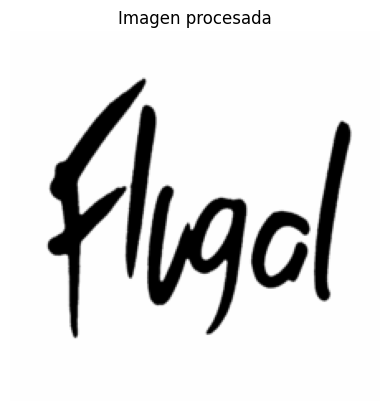

127.0.0.1 - - [22/Jun/2024 20:29:06] "POST /predict HTTP/1.1" 200 -


37


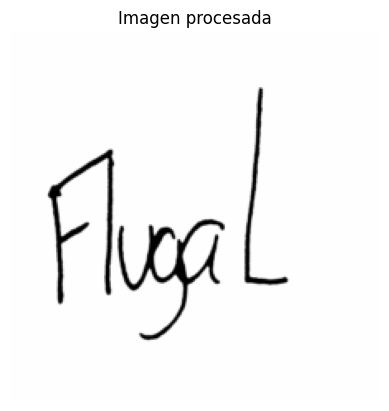

127.0.0.1 - - [22/Jun/2024 20:29:54] "POST /predict HTTP/1.1" 200 -


37


In [ ]:
# Iniciar Flask en un hilo
flask_thread = threading.Thread(target=run_flask)
flask_thread.start()